In [1]:
import numpy as np
import pandas as pd
import os
from sklearn import svm
from sklearn import metrics
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats, linalg
import warnings
from sklearn.exceptions import ConvergenceWarning
def conv_r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
def conv_z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
%matplotlib inline

In [3]:
dataset_learn = "Sherlock"
path = "/Users/cablab/Desktop/VAM/data"
nR = 122
thres = 0.01

nsubj = 16
wsize = 30
nT = 1924

print('  model learn from = '+str(dataset_learn)+' win'+str(wsize))

  model learn from = Sherlock win30


# load Behavioral Data

In [4]:
# load valence
valence_learn = scipy.io.loadmat(path + '/beh/preprocessed/group_average/conv_slidingBeh/sherlock_valence.mat')['sliding_beh']
valence_learn = np.squeeze(valence_learn)

# load arousal
arousal_learn = scipy.io.loadmat(path + '/beh/preprocessed/group_average/conv_slidingBeh/sherlock_arousal.mat')['sliding_beh']
arousal_learn = np.squeeze(arousal_learn)

print('model learn: valence shape' + str(valence_learn.shape))
print('model learn: arousal shape' + str(arousal_learn.shape))

model learn: valence shape(1894,)
model learn: arousal shape(1894,)


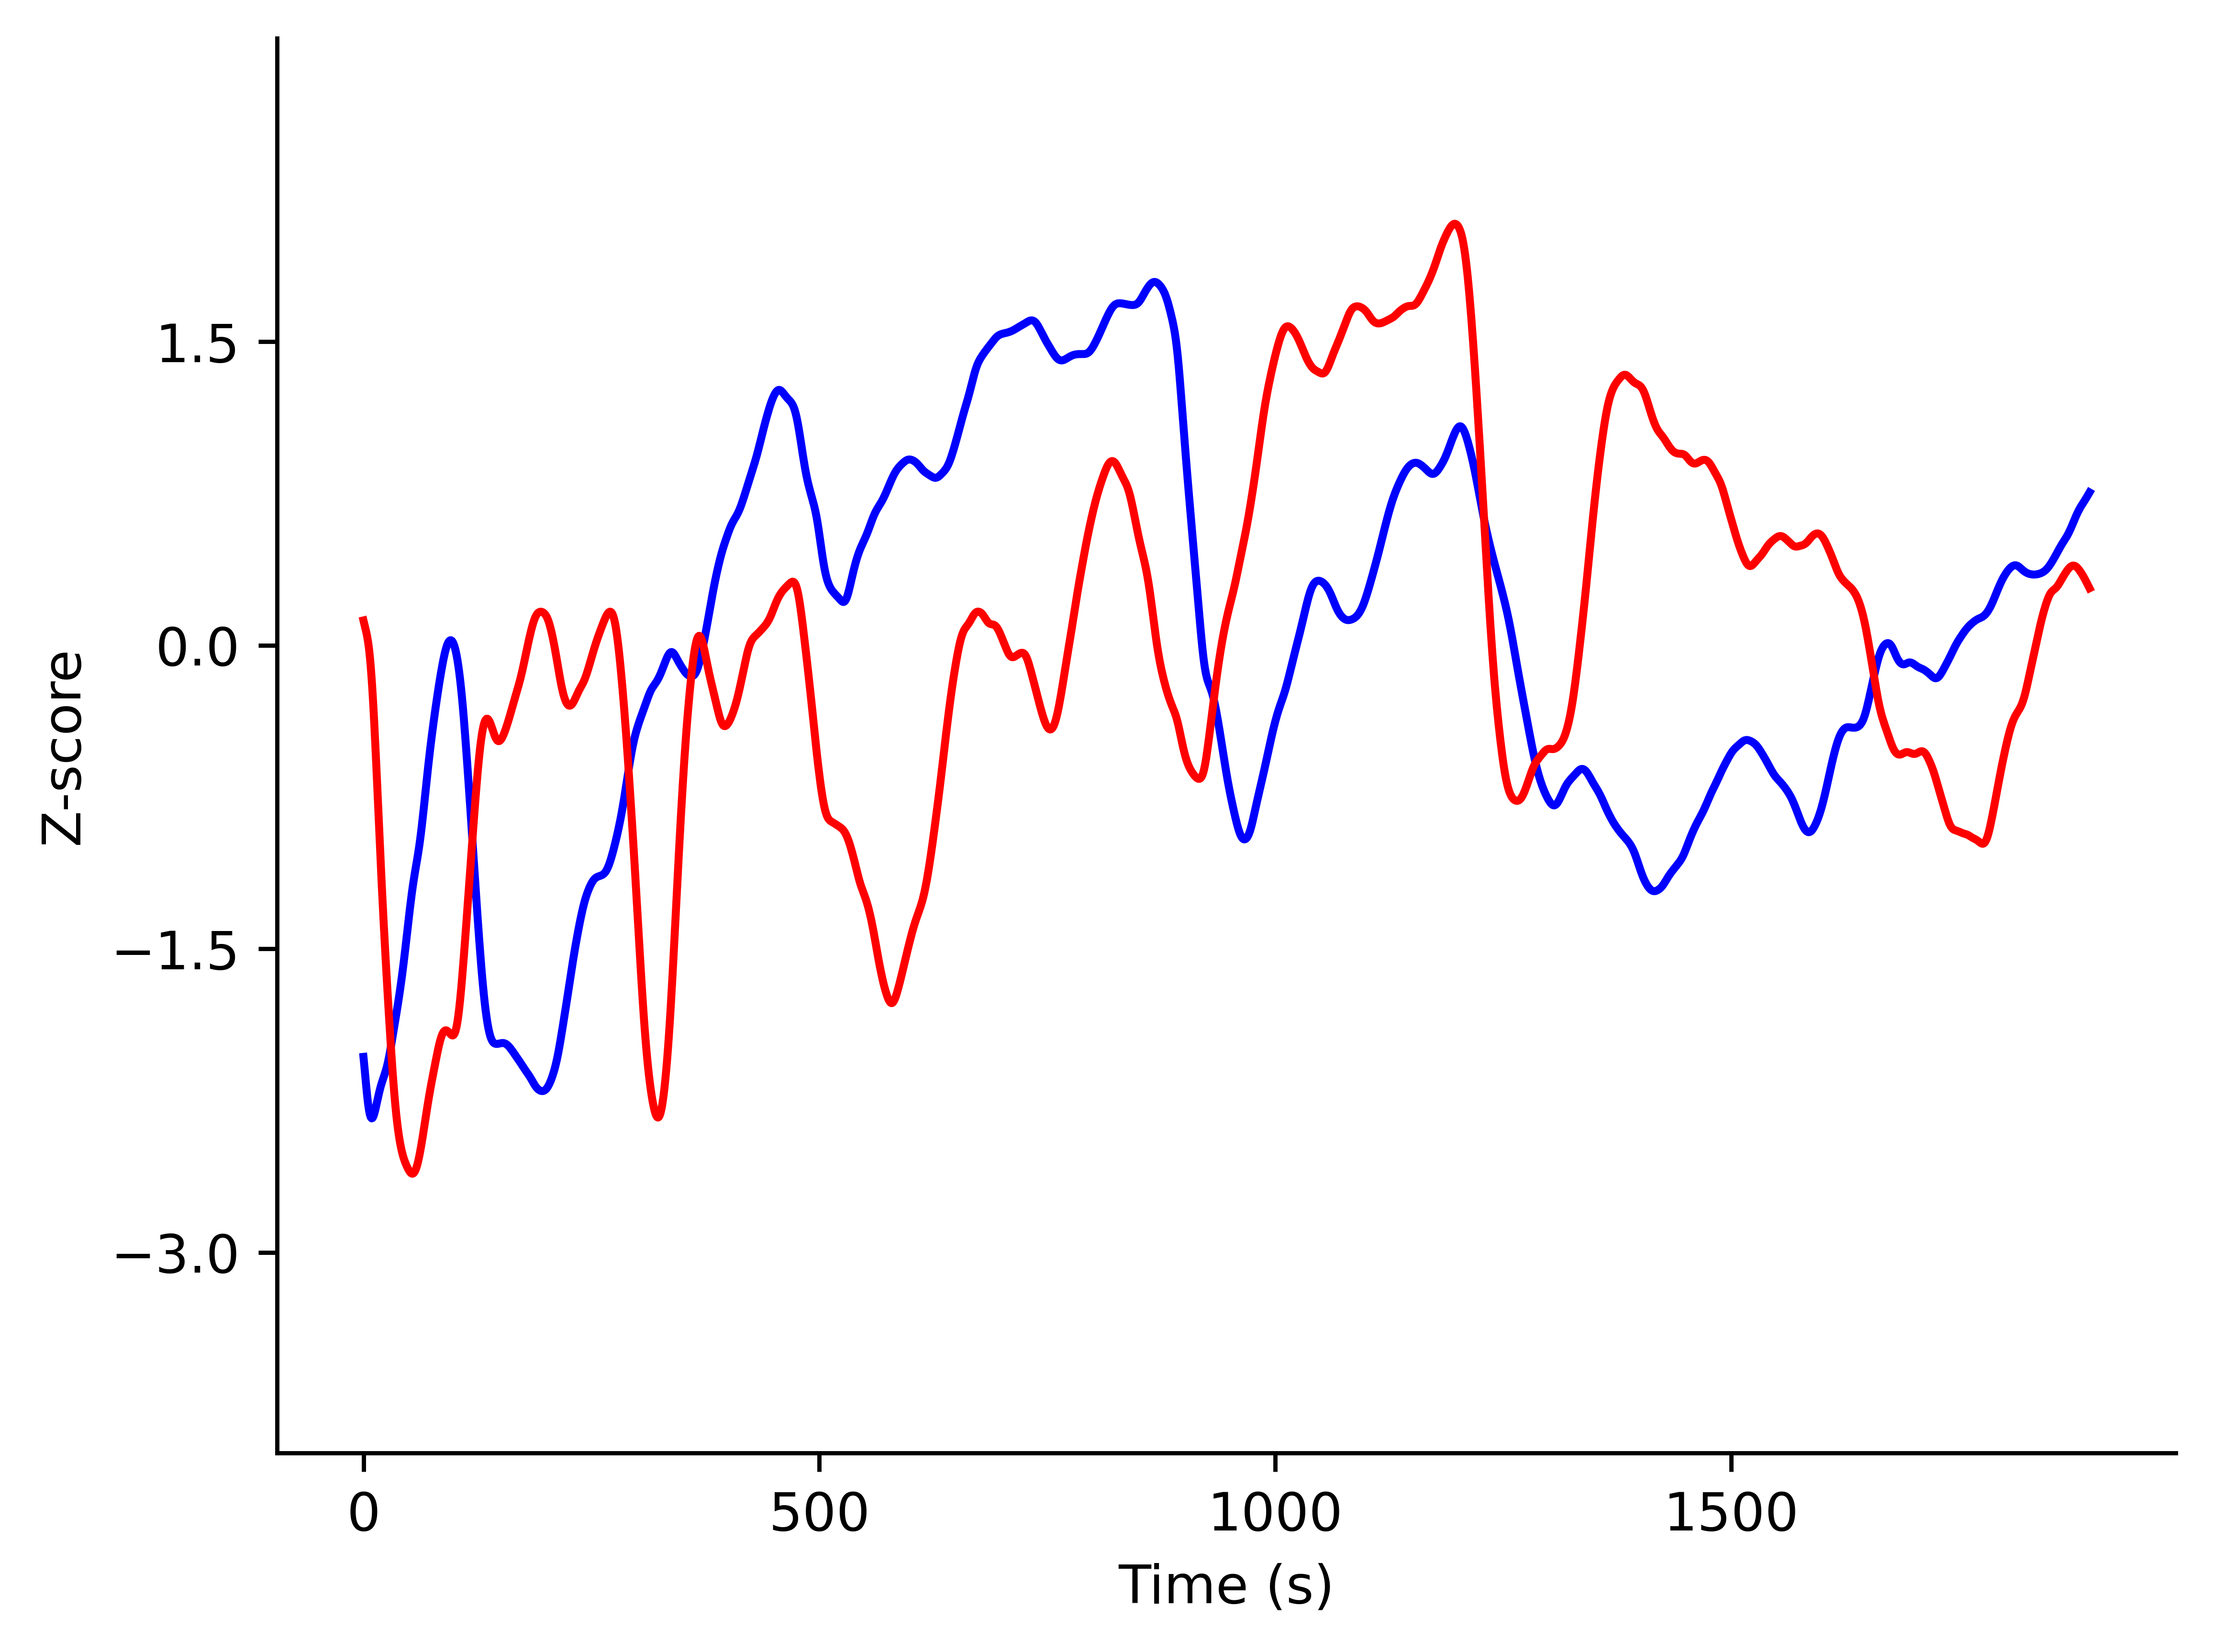

In [5]:
# plot and run correlation
time_learn = range(1894)

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(time_learn, valence_learn, color = 'blue')
plt.plot(time_learn, arousal_learn, color = 'red')
plt.ylim([-3.99, 3])
plt.yticks(np.arange(-3,3,1.5))
plt.xticks(np.arange(0,2000,500))
plt.xlabel('Time (s)')
plt.ylabel('Z-score')
fig.set_dpi(800)
plt.show()

# Load Brain Data

In [6]:
import mat73
dynFC_learn = mat73.loadmat(path + '/brain/' + dataset_learn + '/a_output/FC/sliding-dynFeat.mat')['dynFeat']
# zscore per feature
dynFC_learn = scipy.stats.zscore(dynFC_learn,2,nan_policy='omit') 
print('  model learn: brain entire feature shape '+str(dynFC_learn.shape))

  model learn: brain entire feature shape (16, 7381, 1894)


# Leave-one-subject-out Cross-validation

In [7]:
def losocv(fmri, behavior, nsubj, rvals):
    output_acc, output_eval, output_pos_feat, output_neg_feat = [], [], np.zeros((nsubj, nR, nR)), np.zeros((nsubj, nR, nR))
    for test_sub in range(nsubj):
        
        # separate train-test subject
        test_fmri = fmri[test_sub,:,:]
        train_fmri = np.delete(fmri,test_sub,0)

        # every training participants' data are concatenated
        # fed as independent instances to the model
        train_feature = np.transpose(train_fmri,(1,0,2))
        train_feature = np.reshape(train_feature,(train_feature.shape[0],train_feature.shape[1]*train_feature.shape[2]))
        train_behavior = []
        for sub in range(nsubj-1):
            train_behavior.append(behavior)
        train_behavior = np.asarray(train_behavior)
        train_behavior = np.reshape(train_behavior,(train_behavior.shape[0]*train_behavior.shape[1]))

        # features: correlation with behavior
        train_subj_corrmat = np.delete(rvals,test_sub,0)

        # feature selection
        pos_feat, neg_feat, all_feat, nanval = [], [], [], 0
        idx = -1
        for feat in range(int(nR*(nR-1)/2)):
            idx=idx+1
                
            if np.any(np.isnan(train_subj_corrmat[:,feat])):
                nanval = nanval+1
                pass
            else:
                [tval,pval] = scipy.stats.ttest_1samp(train_subj_corrmat[:,feat],0)
                if pval < thres:
                    if np.average(train_subj_corrmat[:,feat])>0:
                        all_feat.append(idx)
                        pos_feat.append(idx)
                    elif np.average(train_subj_corrmat[:,feat])<0:
                        all_feat.append(idx)
                        neg_feat.append(idx)
        pos_feat, neg_feat, all_feat = np.asarray(pos_feat), np.asarray(neg_feat), np.asarray(all_feat)

        # summarize feature matrix
        idx = -1
        for i1 in range(nR-1):
            for i2 in range(i1+1,nR):
                idx = idx+1
                if idx in pos_feat:
                    output_pos_feat[test_sub,i1,i2]=1
                    output_pos_feat[test_sub,i2,i1]=1
                if idx in neg_feat:
                    output_neg_feat[test_sub,i1,i2]=1
                    output_neg_feat[test_sub,i2,i1]=1

        train_selected_feat = train_feature[all_feat,:]
        test_selected_feat = test_fmri[all_feat, :]
        test_behavior = behavior

        # if any of the TRs are removed
        rmtr_train = []
        for tm in range(train_selected_feat.shape[1]):
            if np.all(np.isnan(train_selected_feat[:,tm])):
                rmtr_train.append(tm)
        rmtr_train = np.asarray(rmtr_train)
        if len(rmtr_train)>0:
            train_selected_feat = np.delete(train_selected_feat,rmtr_train,1)
            train_behavior = np.delete(train_behavior,rmtr_train,0)

        rmtr_test = []
        for tm in range(test_selected_feat.shape[1]):
            if np.all(np.isnan(test_selected_feat[:, tm])):
                rmtr_test.append(tm)
        rmtr_test = np.asarray(rmtr_test)
        if len(rmtr_test) > 0:
            test_selected_feat = np.delete(test_selected_feat, rmtr_test, 1)
            test_behavior = np.delete(test_behavior,rmtr_test,0)

        # Support vector regression with non-linear kernel
        clf = []
        clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            clf.fit(train_selected_feat.T, train_behavior)
        predicted = clf.predict(test_selected_feat.T)
        output_acc.append(predicted)

        # evaluate
        pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
        mse = metrics.mean_squared_error(test_behavior, predicted)
        rsq = metrics.r2_score(test_behavior, predicted)
        output_eval.append([pearsonr[0], mse, rsq])
        print('  subj '+str(test_sub+1)+' / '+str(nsubj)+': #feat '+str(len(all_feat))+', pearson r='+str(np.round(pearsonr[0],3)),', mse='+str(np.round(mse,3))+', rsq='+str(np.round(rsq,3)))
        print('               (train) ft '+str(train_selected_feat.shape[1])+', beh '+str(train_behavior.shape[0])+
              ', (test) ft '+str(test_selected_feat.shape[1])+', beh '+str(test_behavior.shape[0]))

    output_acc, output_eval, output_pos_feat, output_neg_feat = np.asarray(output_acc), np.asarray(output_eval), np.asarray(output_pos_feat), np.asarray(output_neg_feat)
    return output_acc, output_eval, output_pos_feat, output_neg_feat

# Valence

In [8]:
# calculate correlation with behavior for all FC features
allsubj_corrmat = np.zeros((nsubj,int(nR*(nR-1)/2)))

for sub in range(nsubj):
    for feat in range(int(nR*(nR-1)/2)):
        if np.any(np.isnan(dynFC_learn[sub,feat,:]))==True:
            rval=np.nan
        else:
            [rval,pval] = scipy.stats.pearsonr(dynFC_learn[sub,feat,:], valence_learn)
        allsubj_corrmat[sub,feat] = rval
print(allsubj_corrmat.shape)

(16, 7381)


In [9]:
[output_acc_valence, output_eval_valence, output_pos_feat_valence, output_neg_feat_valence] = losocv(dynFC_learn, valence_learn, nsubj, allsubj_corrmat)


  subj 1 / 16: #feat 629, pearson r=0.617 , mse=0.64, rsq=0.36
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 2 / 16: #feat 771, pearson r=0.576 , mse=0.676, rsq=0.324
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 3 / 16: #feat 656, pearson r=0.514 , mse=0.74, rsq=0.26
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 4 / 16: #feat 763, pearson r=0.539 , mse=0.72, rsq=0.28
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 5 / 16: #feat 773, pearson r=0.625 , mse=0.64, rsq=0.36
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 6 / 16: #feat 678, pearson r=0.504 , mse=0.746, rsq=0.253
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 7 / 16: #feat 689, pearson r=0.624 , mse=0.625, rsq=0.375
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 8 / 16: #feat 792, pearson r=0.398 , mse=0.847, rsq=0.153
     

Prediction result (mean of cross-validations): valence
 pearson r = 0.518
 MSE       = 0.74
 r-squared = 0.26


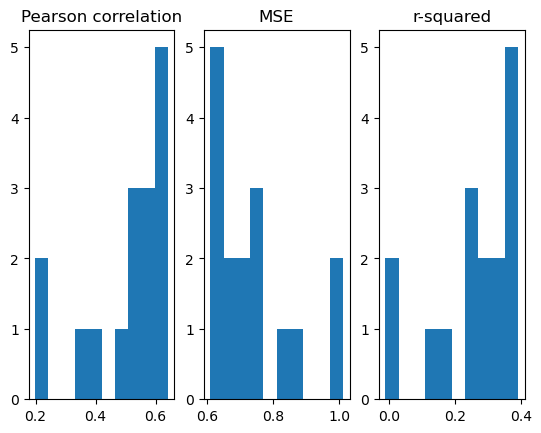

In [10]:
fig, axs = plt.subplots(1,3)
axs[0].hist(output_eval_valence[:,0])
axs[0].set_title('Pearson correlation')
axs[1].hist(output_eval_valence[:,1])
axs[1].set_title('MSE')
axs[2].hist(output_eval_valence[:,2])
axs[2].set_title('r-squared')

print('Prediction result (mean of cross-validations): valence')
print(' pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(output_eval_valence[:,0]))),3)))
print(' MSE       = '+str(np.round(np.mean(output_eval_valence[:,1]),3)))
print(' r-squared = '+str(np.round(np.mean(output_eval_valence[:,2]),3)))

In [11]:
savepath='/Users/cablab/Desktop/VAM/results/sherlock/within_prediction/'
result = {'acc':output_acc_valence, 'eval':output_eval_valence, 'pos_feat':output_pos_feat_valence, 'neg_feat':output_neg_feat_valence}
if os.path.exists(savepath)==0:
    os.makedirs(savepath)
scipy.io.savemat(savepath+'sliding_valence.mat',result)

# Arousal

In [12]:
# calculate correlation with behavior for all FC features
allsubj_corrmat = np.zeros((nsubj,int(nR*(nR-1)/2)))

for sub in range(nsubj):
    for feat in range(int(nR*(nR-1)/2)):
        if np.any(np.isnan(dynFC_learn[sub,feat,:]))==True:
            rval=np.nan
        else:
            [rval,pval] = scipy.stats.pearsonr(dynFC_learn[sub,feat,:], arousal_learn)
        allsubj_corrmat[sub,feat] = rval
print(allsubj_corrmat.shape)

(16, 7381)


In [13]:
[output_acc_arousal, output_eval_arousal, output_pos_feat_arousal, output_neg_feat_arousal] = losocv(dynFC_learn, arousal_learn, nsubj, allsubj_corrmat)


  subj 1 / 16: #feat 779, pearson r=0.49 , mse=0.765, rsq=0.235
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 2 / 16: #feat 749, pearson r=0.592 , mse=0.661, rsq=0.339
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 3 / 16: #feat 777, pearson r=0.618 , mse=0.624, rsq=0.376
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 4 / 16: #feat 753, pearson r=0.612 , mse=0.631, rsq=0.369
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 5 / 16: #feat 783, pearson r=0.547 , mse=0.702, rsq=0.298
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 6 / 16: #feat 748, pearson r=0.557 , mse=0.7, rsq=0.299
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 7 / 16: #feat 782, pearson r=0.772 , mse=0.438, rsq=0.562
               (train) ft 28410, beh 28410, (test) ft 1894, beh 1894
  subj 8 / 16: #feat 843, pearson r=0.612 , mse=0.637, rsq=0.363


Prediction result (mean of cross-validations): arousal
 pearson r = 0.575
 MSE       = 0.68
 r-squared = 0.32


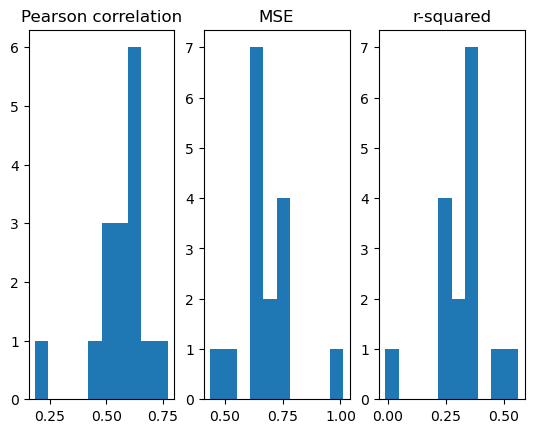

In [14]:
fig, axs = plt.subplots(1,3)
axs[0].hist(output_eval_arousal[:,0])
axs[0].set_title('Pearson correlation')
axs[1].hist(output_eval_arousal[:,1])
axs[1].set_title('MSE')
axs[2].hist(output_eval_arousal[:,2])
axs[2].set_title('r-squared')

print('Prediction result (mean of cross-validations): arousal')
print(' pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(output_eval_arousal[:,0]))),3)))
print(' MSE       = '+str(np.round(np.mean(output_eval_arousal[:,1]),3)))
print(' r-squared = '+str(np.round(np.mean(output_eval_arousal[:,2]),3)))

In [15]:
savepath='/Users/cablab/Desktop/VAM/results/sherlock/within_prediction/'
result = {'acc':output_acc_arousal, 'eval':output_eval_arousal, 'pos_feat':output_pos_feat_arousal, 'neg_feat':output_neg_feat_arousal}
if os.path.exists(savepath)==0:
    os.makedirs(savepath)
scipy.io.savemat(savepath+'/sliding_arousal.mat',result)